<a href="https://colab.research.google.com/github/belanasaikiran/Team-6-Big-Data-Project/blob/main/temp/Stanford_cars_Xception_Model_for_Car_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Make & Model Detection:
This project aims to detect the make and model of a given car.  
We use Stanford Car DataSet for training the model. We have over 196 classes in total for model detection.

We are dealing with 12946 images of training data. 2000 ish images for testing.

**Team Members**:

*   Ariannah Black
*   Sai Kiran Belana
*   Ummea Salma
*   Md Ishtyaq Mahmud

The DataSet is structured in the following manner

```
DataSet
├── data
│   ├── meta.csv
│   ├── test.csv
│   └── train.csv
└── images
    ├── cars_test
    └── cars_train
```


## Todo:
- [x] Import the DataSet.
- [x] Preprocessing
- [x] Feature Selection
- [x] Model Selection
- [x] Training the Model
- [x] Test the Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score
from keras import backend as K
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
K.image_data_format()

'channels_last'

In [2]:
BATCH_SIZE = 32
EPOCHS = 50
k_folds = 2
TTA_STEPS = 5
PATIENCE = 6
SEED = 2019
BASE_MODEL = Xception
IMAGE_SIZE = 299

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [35]:
!unzip gdrive/MyDrive/Big\ Data\ Analytics\ Project\ \(Team\ 6\)/DataSet/DataSet.zip > /dev/null # output to null
# !unzip 'gdrive/MyDrive/Big Data Analytics Project (Team 6)/DataSet/2019-3rd-ml-month-with-kakr.zip' > /dev/null

replace DataSet/data/meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Checking if image dataset is loaded

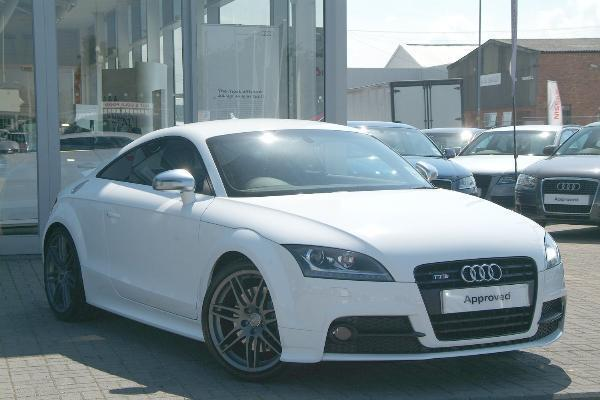

In [37]:
from PIL import Image

im = Image.open("/content/DataSet/images/cars_train/00001.jpg", "r")
im

## Load the Train & Test Datasets

In [131]:
DATA_PATH = '/content/DataSet/'
IMG_DATA_PATH = DATA_PATH + "images/"
CSV_DATA_PATH = DATA_PATH + "data/"

TRAIN_IMG_PATH = os.path.join(IMG_DATA_PATH, 'cars_train/')
TEST_IMG_PATH = os.path.join(IMG_DATA_PATH, 'cars_test/')

df_train = pd.read_csv(os.path.join(CSV_DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(CSV_DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(CSV_DATA_PATH, 'meta.csv'))

model_path = '/content/'

if not os.path.exists(model_path):
    os.mkdir(model_path)

In [132]:
def print_df(df, name):
    print(name + " Data:")
    print(df.info())
    print(df.shape)
    print("\n")

print_df(df_train, "Train")
print_df(df_test, "Test ")
print_df(df_class, "Class")

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12948 entries, 0 to 12947
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12948 non-null  int64 
 1   x1          12948 non-null  int64 
 2   y1          12948 non-null  int64 
 3   x2          12948 non-null  int64 
 4   y2          12948 non-null  int64 
 5   class       12948 non-null  int64 
 6   fname       12948 non-null  object
dtypes: int64(6), object(1)
memory usage: 708.2+ KB
None
(12948, 7)


Test  Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 0 to 3236
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3237 non-null   int64 
 1   x1          3237 non-null   int64 
 2   y1          3237 non-null   int64 
 3   x2          3237 non-null   int64 
 4   y2          3237 non-null   int64 
 5   class       3237 non-null   int64 
 6   fname  

Fixing the fname for one of the value in CSV

In [133]:
# fix the file names here
df_train.loc[9998, 'fname'] = '09999.jpg'

# Data Preprocessing

### Helper Function: **Image Cropper**

In [134]:
model_path = '/content/'

def image_box_cropper(img_name, path_images, data_frame, margin=0, size=(IMAGE_SIZE,IMAGE_SIZE)):
    PATH = path_images

    img = PIL.Image.open(os.path.join(PATH, img_name))
    # once we run below command, we delete the columns as well.
    pos = data_frame.loc[data_frame["fname"] == img_name, ['x1', 'y1', 'x2', 'y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    croppedImage = img.crop((x1, y1, x2, y2)).resize(size)

    return croppedImage

In [135]:
!rm -r /content/cropped_train/
!rm -r /content/cropped_test/


In [136]:
%%time
TRAIN_CROPPED_PATH = '/content/cropped_train'
TEST_CROPPED_PATH = '/content/cropped_test'

if not os.path.isdir(TRAIN_CROPPED_PATH):
  os.mkdir(TRAIN_CROPPED_PATH)

if not os.path.isdir(TEST_CROPPED_PATH):
  os.mkdir(TEST_CROPPED_PATH)

for i, row in df_train.iterrows():
    cropped = image_box_cropper(row['fname'], TRAIN_IMG_PATH, df_train)
    cropped.save(os.path.join(TRAIN_CROPPED_PATH, row['fname']))

    if i == len(df_train) - 1:
      print("All Train Images have been cropped")

for i, row in df_test.iterrows():
    cropped = image_box_cropper(row['fname'], TEST_IMG_PATH, df_test)
    cropped.save(os.path.join(TEST_CROPPED_PATH, row['fname']))

    if i == len(df_test) - 1:
      print("All Test Images have been cropped")

All Train Images have been cropped
All Test Images have been cropped
CPU times: user 2min 51s, sys: 4.56 s, total: 2min 56s
Wall time: 2min 58s


In [147]:
df_train['class'] = df_train['class'].astype('str')
df_train = df_train[['fname', 'class']]
df_test = df_test[['fname']]

## Setting up our Helper Functions

In [137]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [138]:
def get_callback(model_name, patient):
    ES = EarlyStopping(
        monitor='val_f1_m',
        patience=patient,
        mode='max',
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'val_f1_m',
        factor = 0.5,
        patience = patient / 2,
        min_lr=0.000001,
        verbose=1,
        mode='max')
    MC = ModelCheckpoint(
        filepath=model_name,
        monitor='val_f1_m',
        verbose=1,
        save_best_only=True,
        mode='max')

    return [ES, RR, MC]

# Load the Xception Model

In [139]:
def get_model(model_name, image_size):
    base_model = model_name(weights='imagenet', input_shape=(image_size,image_size,3), include_top=False)
    #base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2048, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(196, activation='softmax', kernel_initializer='lecun_normal'))

    optimizer = optimizers.Nadam(lr=0.0003)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1_m, precision_m, recall_m])

    return model

In [141]:
model = get_model(BASE_MODEL, IMAGE_SIZE)
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 196)               401604    
                                                                 
Total params: 25459436 (97.12 MB)
Trainable params: 25404908 (96.91 MB)
Non-trainable params: 54528 (213.00 KB)
________

### Get Random Eraser:
The function generates a new function, eraser, which when applied to an image, randomly obscures part of the image with a rectangle of random size, aspect ratio, and color.


Source: https://github.com/yu4u/cutout-random-erasing

In [142]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


## Data Augumentation

In [143]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True,  # divide each input by its std
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    shear_range=0.5,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    preprocessing_function = get_random_eraser(v_l=0, v_h=255),
    )

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True  # divide each input by its std
    )
test_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True,  # divide each input by its std
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    shear_range=0.5,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    preprocessing_function = get_random_eraser(v_l=0, v_h=255),
    )

In [144]:
# skf = StratifiedKFold(n_splits=k_folds)
skf = KFold(n_splits=k_folds)

In [148]:
%%time
j = 1
model_names = []
for (train_index, valid_index) in skf.split(
    df_train['fname'],
    df_train['class']):


    traindf = df_train
    validdf = df_train.iloc[valid_index, :].reset_index()

    print("\n *** K Fold Validation step => %d/%d ***" % (j,k_folds))

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=traindf,
        directory=TRAIN_CROPPED_PATH,
        x_col='fname',
        y_col='class',
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=True
        )

    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=validdf,
        directory=TRAIN_CROPPED_PATH,
        x_col='fname',
        y_col='class',
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=True
        )

    model_name = model_path + str(j) + '_' + 'Xception' + '.hdf5'
    model_names.append(model_name)

    model = get_model(BASE_MODEL, IMAGE_SIZE)

    try:
        model.load_weights(model_name)
    except:
        pass

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(traindf.index) / BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=valid_generator,
        validation_steps=len(validdf.index) / BATCH_SIZE,
        verbose=1,
        shuffle=False,
        callbacks = get_callback(model_name, PATIENCE)
        )

    j+=1


 *** K Fold Validation step => 1/2 ***
Found 12948 validated image filenames belonging to 196 classes.
Found 6474 validated image filenames belonging to 196 classes.


Epoch 1/50
156/404 [==========>...................] - ETA: 6:25 - loss: 0.7727 - acc: 0.7859 - f1_m: 0.7913 - precision_m: 0.8539 - recall_m: 0.7392

KeyboardInterrupt: 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'lr'])


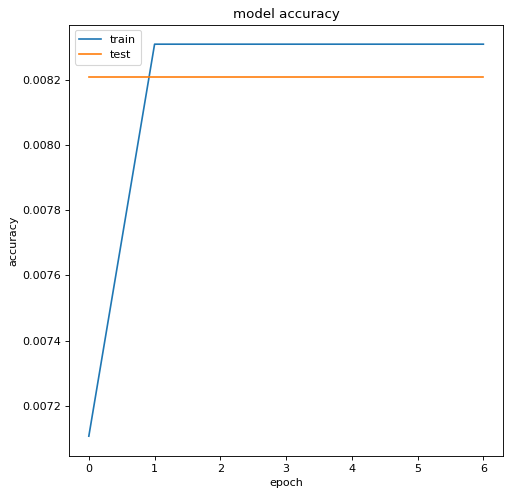

In [ ]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

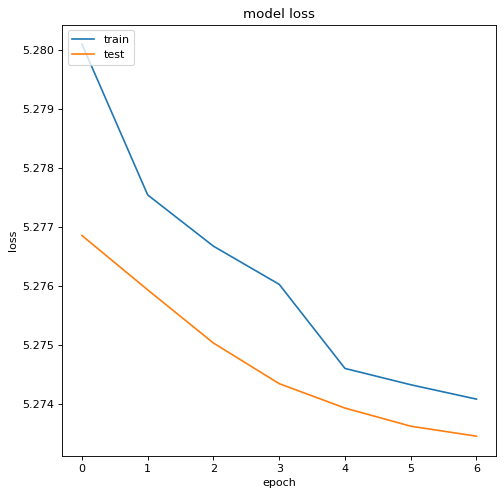

In [ ]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

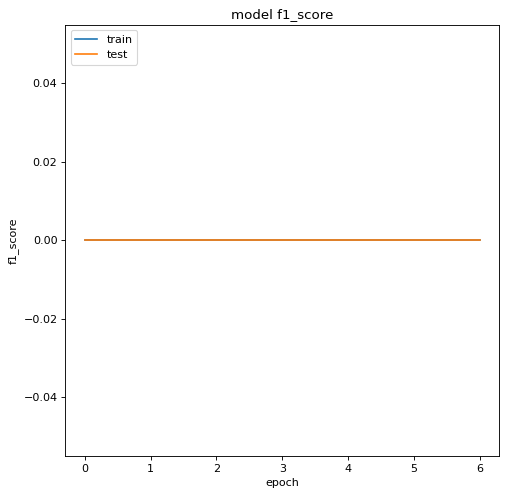

In [ ]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROPPED_PATH,
    x_col='fname',
    y_col=None,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 6150 validated image filenames.


In [ ]:
prediction = []
for i, name in enumerate(model_names):
    model = get_model(BASE_MODEL, IMAGE_SIZE)
    model.load_weights(name)

    preds = []
    for j in range(TTA_STEPS):
        test_generator.reset()
        pred = model.predict_generator(
            generator=test_generator,
            steps = len(df_test)/BATCH_SIZE,
            verbose=1
        )
        preds.append(pred)
    pred_tta = np.mean(preds, axis=0)

    prediction.append(pred_tta)

y_pred = np.mean(prediction, axis=0)

192/192 [==============================] - 126s 653ms/step


192/192 [==============================] - 125s 648ms/step


In [ ]:
preds_class_indices=np.argmax(y_pred, axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
final_pred = [labels[k] for k in preds_class_indices]

In [ ]:
final_result = pd.read_csv(os.path.join(DATA_PATH, 'final_result.csv'))
final_result["class"] = final_pred
final_result.to_csv("final_result.csv", index=False)
final_result.head()

img_file class
0  test_00001.jpg   124
1  test_00002.jpg    98
2  test_00003.jpg   157
3  test_00004.jpg    94
4  test_00005.jpg    18

### Let's Plot some images based on the predicted values by our model

In [ ]:
!cp /content/DataSet/data/test.csv /content/stanford_cars_final_results.csv

### Plotting images - test data

01449.jpg
143
class_name:  Jaguar XK XKR 2012
original_class_name:  Jaguar XK XKR 2012
01129.jpg
39
class_name:  Bentley Arnage Sedan 2009
original_class_name:  Bentley Arnage Sedan 2009
00962.jpg
103
class_name:  Fisker Karma Sedan 2012
original_class_name:  Ferrari 458 Italia Coupe 2012
02952.jpg
185
class_name:  Toyota Sequoia SUV 2012
original_class_name:  Toyota Sequoia SUV 2012
02770.jpg
51
class_name:  Audi 100 Sedan 1994
original_class_name:  Cadillac SRX SUV 2012
01309.jpg
96
class_name:  Dodge Charger SRT-8 2009
original_class_name:  Dodge Charger SRT-8 2009
00533.jpg
23
class_name:  Nissan Leaf Hatchback 2012
original_class_name:  Audi S4 Sedan 2007
03029.jpg
163
class_name:  Mercedes-Benz E-Class Sedan 2012
original_class_name:  Mercedes-Benz E-Class Sedan 2012
01285.jpg
161
class_name:  Mercedes-Benz C-Class Sedan 2012
original_class_name:  Mercedes-Benz C-Class Sedan 2012
01790.jpg
153
class_name:  Land Rover Range Rover SUV 2012
original_class_name:  Land Rover Range Rov

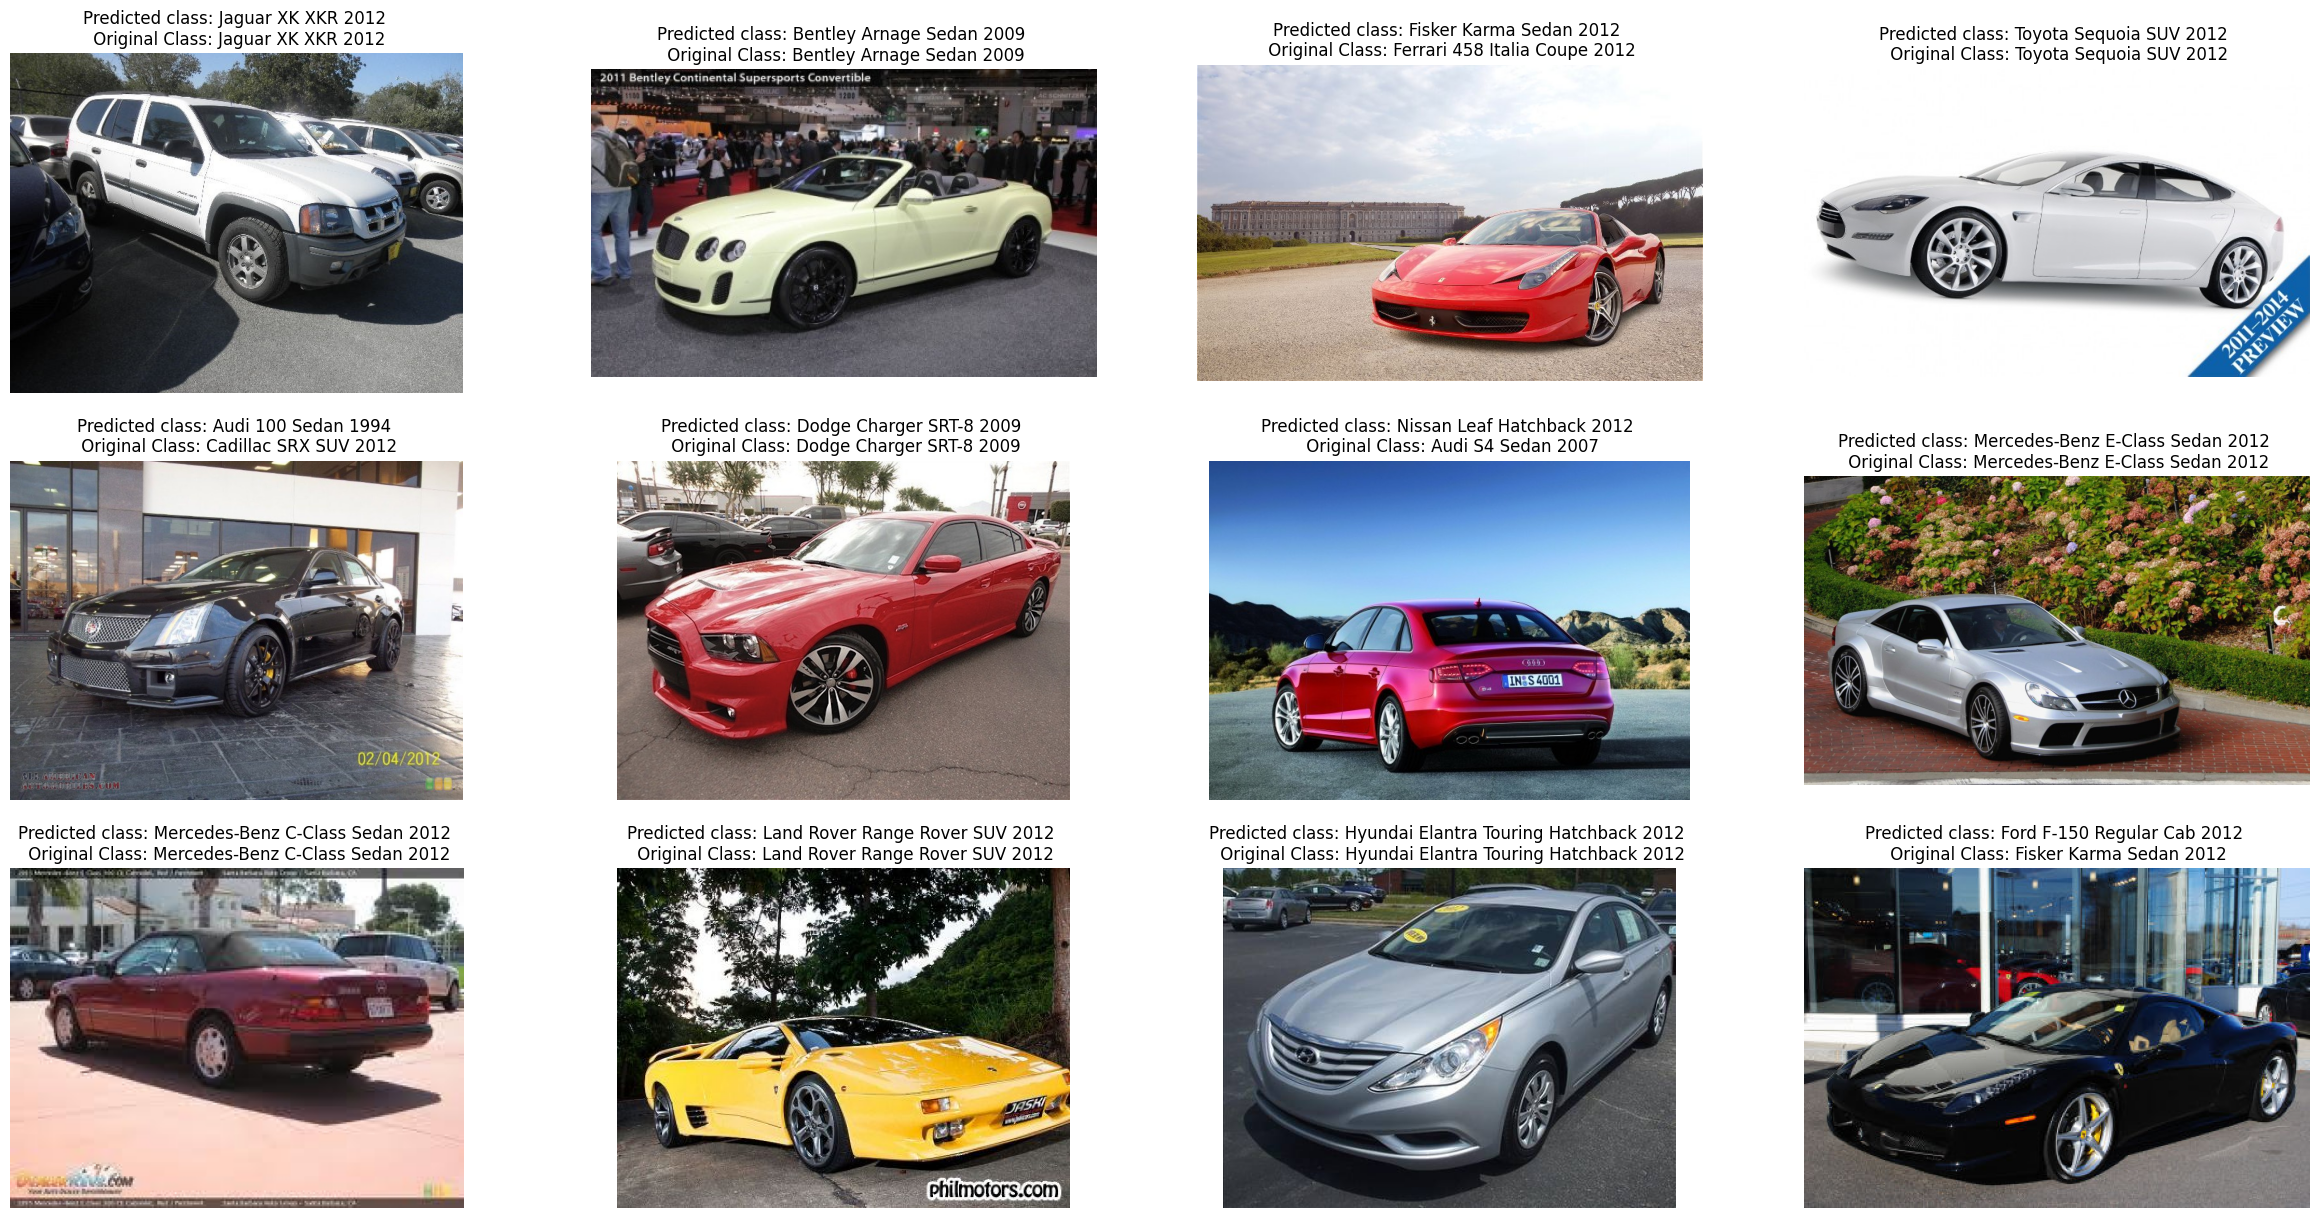

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

# Read the final_result.csv file
final_result = pd.read_csv("/content/stanford_cars_final_result.csv")

# Get a random sample of 10 images
images = final_result.sample(n=12)

# Read the class.csv file
class_dfa = pd.read_csv("/content/class.csv")

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(30, 15))

# Iterate through the images and display them
for idx, row in enumerate(images.iterrows()):
    # row[0] is the index, row[1] is the data
    image_file = row[1]["fname"]
    print(row[1]["fname"])
    print(row[1]["class"])

    # Read the image
    image_path = os.path.join("/content/DataSet/images/cars_test/", image_file)
    image = cv2.imread(image_path)

    # Convert color from BGR to RGB (since cv2 reads images in BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the class name
    index = row[1]["predicted_class"]
    class_name = class_dfa["name"].iloc[index]  # Adjusted to index without +1 assuming zero-based indexing in class_dfa
    print("class_name: ", class_name)

    # original class name
    original_class_name = class_dfa["name"].iloc[row[1]["class"]]  # Adjusted to index without +1 assuming zero-based indexing in class_dfa
    print("original_class_name: ", original_class_name)

    # Display the image
    ax = axes[idx // 4, idx % 4]  # Use idx which is 0-9 for subplots
    ax.imshow(image)
    ax.set_title(f"Predicted class: {class_name} \n Original Class: {original_class_name}")
    ax.axis("off")

# Show the plot
plt.show()